In [1]:
from __future__ import division, print_function
import numpy as np
import cPickle as pickle
import os, glob

from utils import models
from utils.sample_helpers import JumpProposal, get_parameter_groups

from enterprise.pulsar import Pulsar
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from astropy.time import Time

# post-proc stuff
import matplotlib.pyplot as plt
import pandas as pd

from utils.UL_uncert import UL_uncert
from acor import acor
from corner import corner

%matplotlib inline

# custom BWM model and block

In [2]:
from enterprise import constants as const
from enterprise.signals import parameter
from enterprise.signals import prior
from enterprise.signals import utils
from enterprise.signals import deterministic_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

def red_noise_block(prior='log-uniform', Tspan=None):
    """
    Returns red noise model:
        1. Red noise modeled as a power-law with 30 sampling frequencies
    :param prior:
        Prior on log10_A. Default if "log-uniform". Use "uniform" for
        upper limits.
    :param Tspan:
        Sets frequency sampling f_i = i / Tspan. Default will
        use overall time span for indivicual pulsar.
    """

    # red noise parameters
    if prior == 'uniform':
        log10_A = parameter.LinearExp(-20, -11)
    elif prior == 'log-uniform':
        log10_A = parameter.Uniform(-20, -11)
    elif prior == 'log-normal':
        log10_A = parameter.Normal(-15, 4)
    else:
        raise NotImplementedError('Unknown prior for red noise amplitude!')

    gamma = parameter.Uniform(0, 7)

    # red noise signal
    pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
    rn = gp_signals.FourierBasisGP(pl, components=30, Tspan=Tspan)

    return rn


def bwm_block(Tmin, Tmax, amp_prior='log-uniform',
              skyloc=None, logmin=-18, logmax=-11,
              name='bwm'):
    """
    Returns deterministic GW burst with memory model:
        1. Burst event parameterized by time, sky location,
        polarization angle, and amplitude
    :param Tmin:
        Min time to search, probably first TOA (MJD).
    :param Tmax:
        Max time to search, probably last TOA (MJD).
    :param amp_prior:
        Prior on log10_A. Default if "log-uniform". Use "uniform" for
        upper limits.
    :param skyloc:
        Fixed sky location of BWM signal search as [cos(theta), phi].
        Search over sky location if ``None`` given.
    :param logmin:
        log of minimum BWM amplitude for prior (log10)
    :param logmax:
        log of maximum BWM amplitude for prior (log10)
    :param name:
        Name of BWM signal.
    """

    # BWM parameters
    amp_name = '{}_log10_A'.format(name)
    if amp_prior == 'uniform':
        log10_A_bwm = parameter.LinearExp(logmin, logmax)(amp_name)
    elif amp_prior == 'log-uniform':
        log10_A_bwm = parameter.Uniform(logmin, logmax)(amp_name)
    elif amp_prior == 'log-normal':
        log10_A_bwm = parameter.Normal(logmin, logmax)(amp_name)
    else:
        raise NotImplementedError('Unknown prior for BWM amplitude!')

    pol_name = '{}_pol'.format(name)
    pol = parameter.Uniform(0, np.pi)(pol_name)

    t0_name = '{}_t0'.format(name)
    t0 = parameter.Uniform(Tmin, Tmax)(t0_name)

    costh_name = '{}_costheta'.format(name)
    phi_name = '{}_phi'.format(name)
    if skyloc is None:
        costh = parameter.Uniform(-1, 1)(costh_name)
        phi = parameter.Uniform(0, 2*np.pi)(phi_name)
    else:
        costh = parameter.Constant(skyloc[0])(costh_name)
        phi = parameter.Constant(skyloc[1])(phi_name)


    # BWM signal
    bwm_wf = utils.bwm_delay(log10_h=log10_A_bwm, t0=t0,
                             cos_gwtheta=costh, gwphi=phi, gwpol=pol)
    bwm = deterministic_signals.Deterministic(bwm_wf, name=name)

    return bwm


def model_bwm(psrs,
              Tmin_bwm=None, Tmax_bwm=None,
              skyloc=None, logmin=-18, logmax=-11,
              upper_limit=False, bayesephem=False, dmgp=False, free_rn=False):
    """
    Reads in list of enterprise Pulsar instance and returns a PTA
    instantiated with BWM model:
    per pulsar:
        1. fixed EFAC per backend/receiver system
        2. fixed EQUAD per backend/receiver system
        3. fixed ECORR per backend/receiver system
        4. Red noise modeled as a power-law with 30 sampling frequencies
        5. Linear timing model.
    global:
        1. Deterministic GW burst with memory signal.
        2. Optional physical ephemeris modeling.
    :param Tmin_bwm:
        Min time to search for BWM (MJD). If omitted, uses first TOA.
    :param Tmax_bwm:
        Max time to search for BWM (MJD). If omitted, uses last TOA.
    :param skyloc:
        Fixed sky location of BWM signal search as [cos(theta), phi].
        Search over sky location if ``None`` given.
    :param logmin:
        log of minimum BWM amplitude for prior (log10)
    :param logmax:
        log of maximum BWM amplitude for prior (log10)
    :param upper_limit:
        Perform upper limit on common red noise amplitude. By default
        this is set to False. Note that when perfoming upper limits it
        is recommended that the spectral index also be fixed to a specific
        value.
    :param bayesephem:
        Include BayesEphem model. Set to False by default
    :param free_rn:
        Use free red noise spectrum model. Set to False by default
    """

    amp_prior = 'uniform' if upper_limit else 'log-uniform'
    #amp_prior = 'log-normal'

    # find the maximum time span to set GW frequency sampling
    tmin = np.min([p.toas.min() for p in psrs])
    tmax = np.max([p.toas.max() for p in psrs])
    Tspan = tmax - tmin

    if Tmin_bwm == None:
        Tmin_bwm = tmin/const.day
    if Tmax_bwm == None:
        Tmax_bwm = tmax/const.day

    # white noise
    s = models.white_noise_block(vary=False)

    # red noise
    if free_rn:
        s += models.free_noise_block(prior=amp_prior, Tspan=Tspan)
    else:
        s += red_noise_block(prior=amp_prior, Tspan=Tspan)

    # GW BWM signal block
    s += bwm_block(Tmin_bwm, Tmax_bwm, amp_prior=amp_prior,
                   skyloc=skyloc, logmin=logmin, logmax=logmax,
                   name='bwm')

    # ephemeris model
    if bayesephem:
        s += deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

    # timing model
    s += gp_signals.TimingModel(use_svd=True)

    # DM variations model
    if dmgp:
        s += models.dm_noise_block(gp_kernel='diag', psd='powerlaw',
                                   prior=amp_prior, Tspan=Tspan)
        s += models.dm_annual_signal()

        # DM exponential dip for J1713's DM event
        dmexp = models.dm_exponential_dip(tmin=54500, tmax=54900)
        s2 = s + dmexp
    
    # set up PTA
    mods = []
    for p in psrs:
        if dmgp and 'J1713+0747' == p.name:
            mods.append(s2(p))
        else:
            mods.append(s(p))

    pta = signal_base.PTA(mods)

    return pta

# UL analysis

In [3]:
TMIN = 53217.0
TMAX = 57387.0
tchunk = np.linspace(TMIN, TMAX, 41)  # break in 2.5% chunks
tlim = []
for ii in range(len(tchunk)-2):
    tlim.append(tchunk[ii:ii+3])

In [4]:
datadir = '/home/pbaker/nanograv/data/nano11'
noisefile = '/home/pbaker/nanograv/data/nano11_setpars.pkl'

psr_name = 'J1744-1134'  # 'J1909-3744'
ephem = 'DE436'

In [5]:
ii_t = None  # 0-40 or None
if ii_t:
    TMIN, CENTER, TMAX = tlim[ii_t]
    chunk = '{:.2f}'.format(CENTER)
else:
    chunk = 'all'

rundir = '/home/pbaker/nanograv/bwm/sngl/det_{0:s}/{1:s}/{2:s}/'.format(ephem, psr_name, chunk)
!mkdir -p $rundir
if ii_t is not None:
    print(CENTER, Time(CENTER, format='mjd').decimalyear)

In [6]:
# read in data from .par / .tim
par = glob.glob(datadir +'/'+ psr_name +'*.par')[0]
tim = glob.glob(datadir +'/'+ psr_name +'*.tim')[0]
psr = Pulsar(par, tim, ephem=ephem, timing_package='tempo2')

with open(noisefile, "rb") as f:
    setpars = pickle.load(f)

In [7]:
U,_ = utils.create_quantization_matrix(psr.toas)
eps = 9
TMIN = np.floor(max(U[:,eps] * psr.toas/const.day))
TMAX = np.ceil(max(U[:,-eps] * psr.toas/const.day))

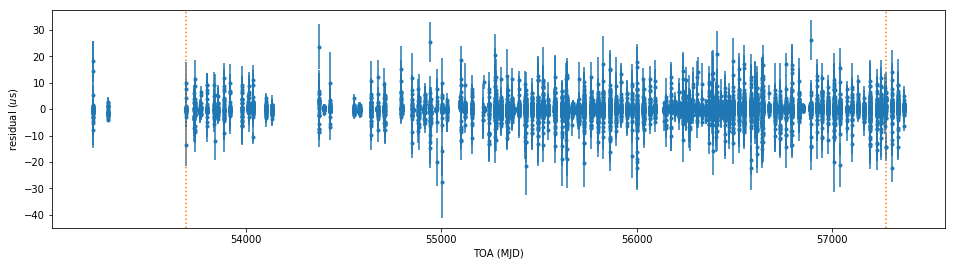

In [8]:
# plot TOA resid for this PSR
toas = psr.toas/const.day
resid = psr.residuals / 1.0e-6
dt = psr.toaerrs / 1.0e-6

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
ax.errorbar(toas, resid, yerr=dt, marker='.', linestyle='none')
ax.axvline(x=TMIN, color='C1', ls=':')
ax.axvline(x=TMAX, color='C1', ls=':')
ax.set_xlabel('TOA (MJD)')
ax.set_ylabel('residual ($u$s)');

In [9]:
#################
##  pta model  ##
#################
logminA = -18 # mean for log-normal
logmaxA = -9  # stdev for log-normal

tmin = psr.toas.min() / 86400
tmax = psr.toas.max() / 86400

if TMIN is not None and TMAX is not None:
    if TMIN<tmin:
        err = "tmin ({:.1f}) BEFORE first TOA ({:.1f})".format(TMIN, tmin)
        raise RuntimeError(err)
    elif TMAX>tmax:
        err = "tmax ({:.1f}) AFTER last TOA ({:.1f})".format(TMAX, tmax)
        raise RuntimeError(err)
    elif TMIN>TMAX:
        err = "tmin ({:.1f}) BEFORE last tmax ({:.1f})".format(TMIN, TMAX)
        raise RuntimeError(err)
    else:
        t0min = TMIN
        t0max = TMAX
else:
    tclip = (tmax - tmin) * 0.05
    t0min = tmin + tclip*2  # clip first 10%
    t0max = tmax - tclip    # clip last 5%

pta = model_bwm([psr],
                upper_limit=False, bayesephem=False,
                logmin=logminA, logmax=logmaxA,
                Tmin_bwm=t0min, Tmax_bwm=t0max)
pta.set_default_params(setpars)


outfile = os.path.join(rundir, 'params.txt')
with open(outfile, 'w') as f:
    for pname in pta.param_names:
        f.write(pname+'\n')

INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_efac to 1.07187
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GUPPI_efac to 1.0809
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GASP_efac to 0.991133
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GASP_efac to 1.17041
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GASP_log10_equad to -6.39164
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_log10_equad to -6.60191
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GUPPI_log10_equad to -6.68187
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GASP_log10_equad to -6.46143
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GASP_log10_ecorr to -6.59984
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr1_2_GASP_log10_ecorr to -6.18313
INFO: enterprise.signals.signal_base: Setting J1744-1134_Rcvr_800_GUPPI_log10_ecorr

In [26]:
N = 500000

###############
##  sampler  ##
###############
# dimension of parameter space
x0 = np.hstack(p.sample() for p in pta.params)
ndim = len(x0)

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.1**2)

# parameter groupings
groups = get_parameter_groups(pta)

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior,
                 cov, groups=groups, outDir=rundir, resume=True)

# add prior draws to proposal cycle
jp = JumpProposal(pta)
sampler.addProposalToCycle(jp.draw_from_prior, 5)
sampler.addProposalToCycle(jp.draw_from_bwm_prior, 10)

draw_bwm_loguni = jp.build_log_uni_draw('bwm_log10_A', logminA, logmaxA)
sampler.addProposalToCycle(draw_bwm_loguni, 10)


# SAMPLE!!
sampler.sample(x0, N, SCAMweight=35, AMweight=10, DEweight=50)

Resuming run from chain file /home/pbaker/nanograv/bwm/sngl/det_DE436/J1744-1134/all//chain_1.txt
Adding DE jump with weight 50
Finished 99.80 percent in 10119.472746 s Acceptance rate = 0.251534
Run Complete


# Post Proc

In [27]:
def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

def bayes_fac(samples, Nmin=200, logAmin=-18, logAmax=-9,
              dAmin=0.01, dAmax=0.5):
    """
    Computes the Savage Dickey Bayes Factor and uncertainty.

    :param samples: MCMC samples of GWB (or common red noise) amplitude
    :param ntol: Tolerance on number of samples in bin

    :returns: (bayes factor, 1-sigma bayes factor uncertainty)
    """

    prior = 1 / (logAmax - logAmin)
    dA = np.linspace(dAmin, dAmax, 100)
    bf = []
    bf_err = []
    mask = [] # selecting bins with more than 200 samples

    for ii, delta in enumerate(dA):
        n = np.sum(samples <= (logAmin + delta))
        N = len(samples)

        post = n / N / delta

        bf.append(prior/post)
        bf_err.append(bf[ii]/np.sqrt(n))

        if n > Nmin:
            mask.append(ii)

    return np.mean(np.array(bf)[mask]), np.std(np.array(bf)[mask])

In [28]:
with open(rundir + '/params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
if prior == 'true-uniform':
    idx_A = par_bwm.index('bwm_A')
else:
    idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

/home/pbaker/.local/opt/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


In [29]:
chain_raw = pd.read_csv(rundir + '/chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [30]:
burnfrac = 0.25
thin = 5

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-5]

corL = acor(chain_L)[0]
N = len(chain_bwm)
print("N = {}, corL = {}".format(N, corL))

N = 10860, corL = 28.9440383942


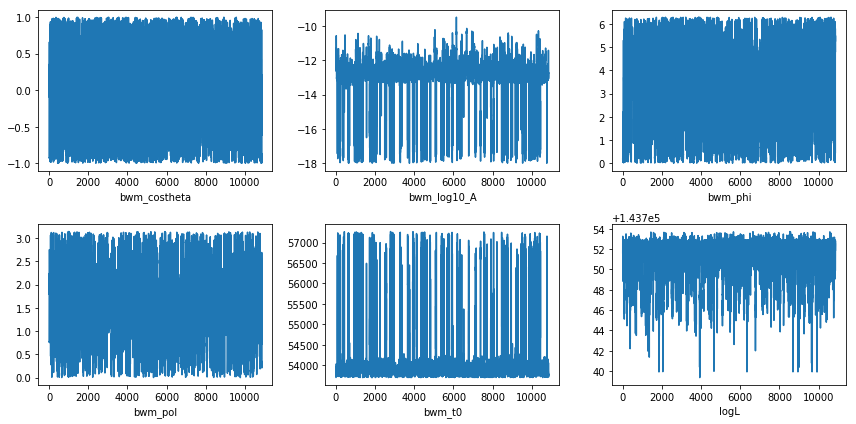

In [31]:
ch_plt = np.hstack([chain_bwm, chain_L.reshape(N,1)])
par_plt = par_bwm + ['logL']
trace_plot(ch_plt, par_plt, cols=3, wid_per_col=4);

In [32]:
xs = np.linspace(-23, -9.5, 100)
prior = 1/np.sqrt(2*np.pi)/logmaxA * np.exp(-0.5*(xs-logminA)**2/logmaxA**2)

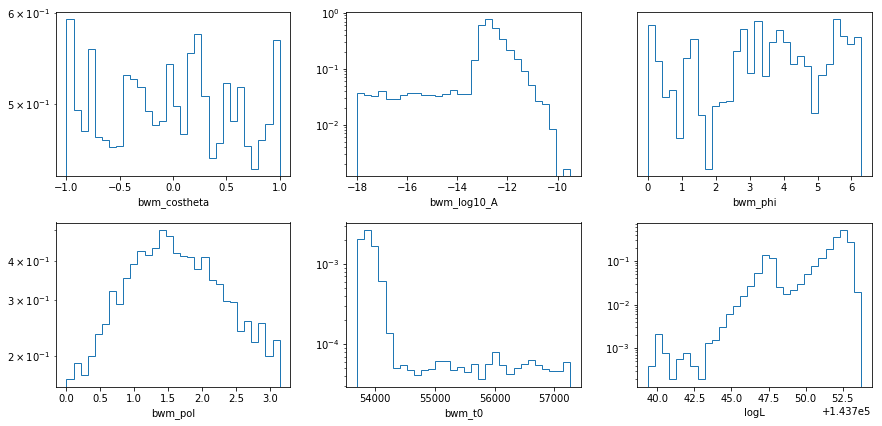

In [33]:
fig = hist_plot(ch_plt, par_plt, cols=3, wid_per_col=4)
for ax in fig.axes:
    ax.set_yscale('log')
#fig.axes[1].plot(xs, prior)

In [34]:
BF, dBF = bayes_fac(chain_bwm[:, idx_A], Nmin=50)

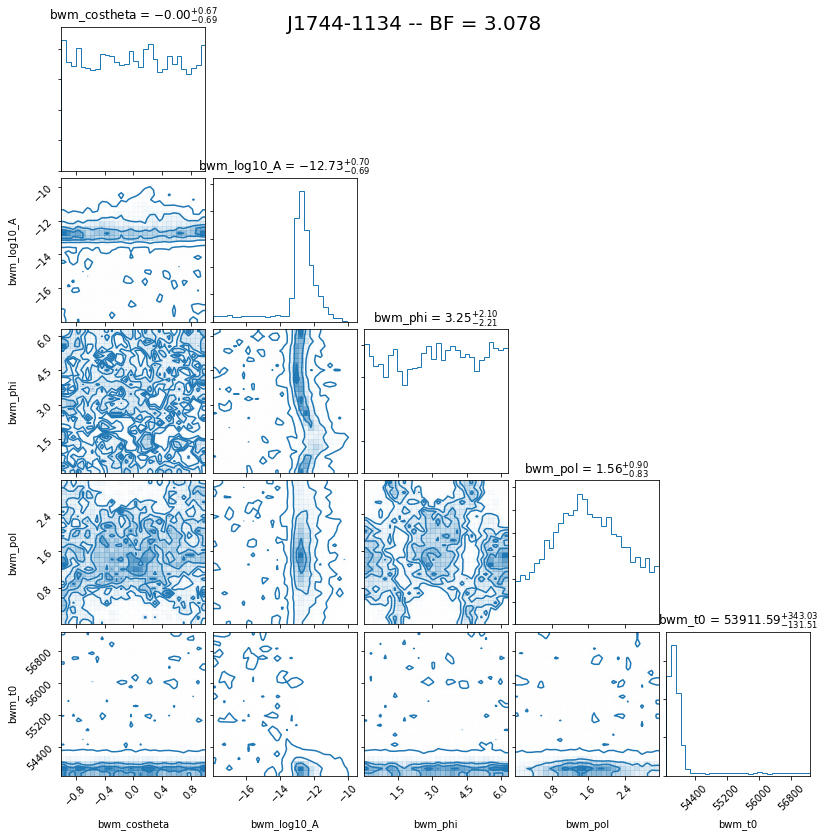

In [35]:
corner_kwargs = {'bins':30,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain_bwm, color='C0', **corner_kwargs);
fig.suptitle("{:s} -- BF = {:.3f}".format(psr_name, BF), fontsize=20);